The CommonDataModel has features to join and filter the CDM tables it contains, which can be used for analysis

In [1]:
import matplotlib.pyplot as plt
import coconnect
coconnect.params['debug_level'] = 0
import glob

In [2]:
inputs = coconnect.tools.load_tsv(glob.glob("temp/1/*.tsv"),dtype=None)
cdm = coconnect.cdm.CommonDataModel.load(inputs=inputs,
                                         do_mask_person_id=False,
                                         format_level=0)
cdm['person'].dropna(axis=1)

,gender_concept_id,year_of_birth,month_of_birth,day_of_birth,birth_datetime,gender_source_value,gender_source_concept_id
person_id,,,,,,,
99481,8507,1947,7,20,1947-07-20 00:00:00.000000,Male,8507
99482,8507,1991,7,9,1991-07-09 00:00:00.000000,Male,8507
99483,8507,1929,7,24,1929-07-24 00:00:00.000000,Male,8507
99484,8507,1964,7,15,1964-07-15 00:00:00.000000,Male,8507
99485,8507,1911,7,29,1911-07-29 00:00:00.000000,Male,8507
...,...,...,...,...,...,...,...
198957,8532,1960,7,16,1960-07-16 00:00:00.000000,Female,8532
198958,8532,1982,7,11,1982-07-11 00:00:00.000000,Female,8532
198959,8532,1945,7,20,1945-07-20 00:00:00.000000,Female,8532


In [3]:
df = cdm.filter({
    'person':{
                'gender_concept_id': lambda x: x == 8507,
                'year_of_birth': lambda x: x < 1970
            },
    'observation':{
                'observation_concept_id':lambda x: x == 4288455,
                  }
     },
    {'person_id':True,'year_of_birth':True,
     'gender_concept_id':True,'observation_source_value':True,
     'observation_datetime':True}
    ).dropna(axis=1)
df

,year_of_birth,gender_concept_id,observation_source_value,observation_datetime
person_id,,,,
99491,1952,8507,8.07351609289685,2021-06-10 00:00:00.000000
99504,1940,8507,19.28425,2023-03-15 00:00:00.000000
99504,1940,8507,18.56546,2021-09-28 00:00:00.000000
99504,1940,8507,28.028697,2022-01-20 00:00:00.000000
99504,1940,8507,0.8493225387535804,2021-02-21 00:00:00.000000
...,...,...,...,...
154432,1953,8507,26.204017,2022-09-26 00:00:00.000000
154437,1941,8507,79.855414,2021-03-01 00:00:00.000000
154437,1941,8507,21.61146,2021-11-19 00:00:00.000000


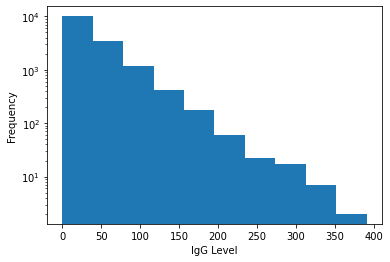

In [4]:
df['observation_source_value'].astype(float).plot.hist()
plt.xlabel('IgG Level')
plt.yscale('log')
plt.show();

In [5]:
import scipy.stats

In [6]:
def get_serology_analysis(_filter):
    def serology_analysis(self):
        df = self.filter(_filter)
        age = 2022 - df['year_of_birth']
        igg = df['observation_source_value'].astype(float)
        res = scipy.stats.linregress(x=age,y=igg)
        return res
    return serology_analysis

ana = get_serology_analysis({'person':{
                'gender_concept_id': lambda x: x == 8507,
                'year_of_birth': lambda x: x < 1970
            },
            'observation':{
                'observation_concept_id':lambda x: x == 4288455,
             }
             })
ana

<function __main__.get_serology_analysis.<locals>.serology_analysis(self)>

In [7]:
cdm.run_analysis(ana)

{'person': {'gender_concept_id': <function <lambda> at 0x12b7e6790>, 'year_of_birth': <function <lambda> at 0x12b7e6820>}, 'observation': {'observation_concept_id': <function <lambda> at 0x12b7e68b0>}}


LinregressResult(slope=0.011092183959903157, intercept=36.464634787039635, rvalue=0.003934806250907787, pvalue=0.6260635621347177, stderr=0.022763251616781152, intercept_stderr=1.6696905891530402)

In [8]:
year_of_birth = [(x,x+20) for x in range(1930,2020,20)]
year_of_birth

[(1930, 1950), (1950, 1970), (1970, 1990), (1990, 2010), (2010, 2030)]

In [9]:
genders = [8507,8532]

In [10]:
coconnect.params['debug_level'] = 2

In [11]:
from itertools import product

results = {}
for ((year_low,year_high),gender) in product(year_of_birth,genders):
    config = {'person':{
                'gender_concept_id': lambda x,gender=gender: x == gender,
                'year_of_birth': lambda x,year_high=year_high,year_low=year_low: ((x < year_high) & (x > year_low))
            },
            'observation':{
                'observation_concept_id':lambda x : x == 4288455,
            }}
    
    ana = get_serology_analysis(config)
    name = f'age_{year_low}_gender_{gender}'
    cdm.add_analysis(ana,name)
    

In [12]:
results = cdm.run_analyses()
results

2022-03-17 11:44:31 - CommonDataModel - INFO - Start thread for <function get_serology_analysis.<locals>.serology_analysis at 0x12b7e69d0> 
2022-03-17 11:44:31 - CommonDataModel - INFO - Start thread for <function get_serology_analysis.<locals>.serology_analysis at 0x12b7e6af0> 
2022-03-17 11:44:31 - CommonDataModel - INFO - Start thread for <function get_serology_analysis.<locals>.serology_analysis at 0x10c4adca0> 
2022-03-17 11:44:31 - CommonDataModel - INFO - Start thread for <function get_serology_analysis.<locals>.serology_analysis at 0x127017550> 
2022-03-17 11:44:31 - CommonDataModel - INFO - Start thread for <function get_serology_analysis.<locals>.serology_analysis at 0x12b8251f0> 
2022-03-17 11:44:31 - CommonDataModel - INFO - Start thread for <function get_serology_analysis.<locals>.serology_analysis at 0x12b825430> 
2022-03-17 11:44:31 - CommonDataModel - INFO - Start thread for <function get_serology_analysis.<locals>.serology_analysis at 0x12b825670> 
2022-03-17 11:44:31 

{'person': {'gender_concept_id': <function <lambda> at 0x12b7e6b80>, 'year_of_birth': <function <lambda> at 0x12b7e6d30>}, 'observation': {'observation_concept_id': <function <lambda> at 0x12b7e6e50>}}
{'person': {'gender_concept_id': <function <lambda> at 0x12b7af550>, 'year_of_birth': <function <lambda> at 0x12b7afca0>}, 'observation': {'observation_concept_id': <function <lambda> at 0x12b7af3a0>}}
{'person': {'gender_concept_id': <function <lambda> at 0x12b7e6c10>, 'year_of_birth': <function <lambda> at 0x12b7e6ca0>}, 'observation': {'observation_concept_id': <function <lambda> at 0x12b7e6dc0>}}


2022-03-17 11:44:31 - CommonDataModel - INFO - finished with <Future at 0x12b7b3520 state=finished returned LinregressResult>
2022-03-17 11:44:31 - CommonDataModel - INFO - finished with <Future at 0x12b7ebe80 state=finished returned LinregressResult>
2022-03-17 11:44:31 - CommonDataModel - INFO - finished with <Future at 0x12b7eb520 state=finished returned LinregressResult>


{'person': {'gender_concept_id': <function <lambda> at 0x1270175e0>, 'year_of_birth': <function <lambda> at 0x12b8250d0>}, 'observation': {'observation_concept_id': <function <lambda> at 0x12b825160>}}
{'person': {'gender_concept_id': <function <lambda> at 0x10c4add30>, 'year_of_birth': <function <lambda> at 0x127017700>}, 'observation': {'observation_concept_id': <function <lambda> at 0x127017670>}}


2022-03-17 11:44:32 - CommonDataModel - INFO - finished with <Future at 0x12fc717c0 state=finished returned LinregressResult>
2022-03-17 11:44:32 - CommonDataModel - INFO - finished with <Future at 0x12fc71a00 state=finished returned LinregressResult>


{'person': {'gender_concept_id': <function <lambda> at 0x12b825280>, 'year_of_birth': <function <lambda> at 0x12b825310>}, 'observation': {'observation_concept_id': <function <lambda> at 0x12b8253a0>}}
{'person': {'gender_concept_id': <function <lambda> at 0x12b8254c0>, 'year_of_birth': <function <lambda> at 0x12b825550>}, 'observation': {'observation_concept_id': <function <lambda> at 0x12b8255e0>}}


2022-03-17 11:44:32 - CommonDataModel - INFO - finished with <Future at 0x12fc71a90 state=finished returned LinregressResult>
2022-03-17 11:44:32 - CommonDataModel - INFO - finished with <Future at 0x12fc71bb0 state=finished returned LinregressResult>
2022-03-17 11:44:32 - CommonDataModel - INFO - finished with <Future at 0x12fc71c10 state=finished returned LinregressResult>


{'person': {'gender_concept_id': <function <lambda> at 0x12b825700>, 'year_of_birth': <function <lambda> at 0x12b825790>}, 'observation': {'observation_concept_id': <function <lambda> at 0x12b825820>}}
{'person': {'gender_concept_id': <function <lambda> at 0x12b825940>, 'year_of_birth': <function <lambda> at 0x12b8259d0>}, 'observation': {'observation_concept_id': <function <lambda> at 0x12b825a60>}}
{'person': {'gender_concept_id': <function <lambda> at 0x12b825b80>, 'year_of_birth': <function <lambda> at 0x12b825c10>}, 'observation': {'observation_concept_id': <function <lambda> at 0x12b825ca0>}}


2022-03-17 11:44:33 - CommonDataModel - INFO - Running analyses took 2.4842209815979004 seconds


{'age_1970_gender_8532': LinregressResult(slope=-0.021243102691067585, intercept=38.6605592995349, rvalue=-0.0027735345372538406, pvalue=0.8565730646304455, stderr=0.11752806051647356, intercept_stderr=5.12179529000808),
 'age_2010_gender_8507': LinregressResult(slope=2.222747671362395, intercept=30.554857289137793, rvalue=0.1476221105654006, pvalue=0.07849885496563927, stderr=1.2541363011035291, intercept_stderr=8.70851000749283),
 'age_1950_gender_8507': LinregressResult(slope=0.08651316957645126, intercept=31.76984095727331, rvalue=0.011963343280191198, pvalue=0.2699826375281989, stderr=0.07842202056417265, intercept_stderr=4.879702922692328),
 'age_1950_gender_8532': LinregressResult(slope=-0.0021204492599500584, intercept=37.86199534709842, rvalue=-0.00029230947740846366, pvalue=0.980840815190395, stderr=0.08829438446144432, intercept_stderr=5.502226140349591),
 'age_1930_gender_8507': LinregressResult(slope=-0.09499515639146493, intercept=45.47287206733538, rvalue=-0.012723548452

In [13]:
import numpy as np

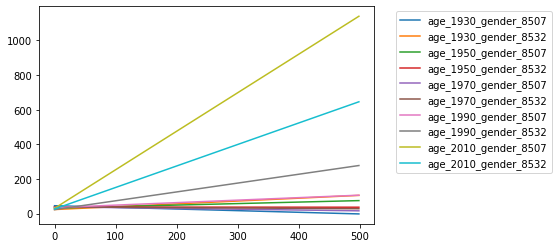

In [15]:
x = np.array([i for i in range(0,500)])
for label,res in sorted(results.items()):
    plt.plot(x, res.intercept + res.slope*x, label=label)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

<AxesSubplot:ylabel='Frequency'>

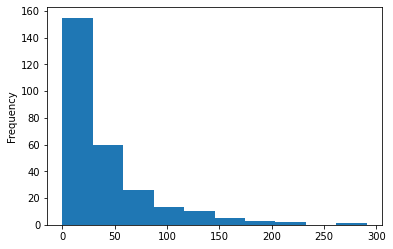

In [17]:
config = {'person':{
                'year_of_birth': lambda x: ((x < 2030) & (x > 2010))
            },
            'observation':{
                'observation_concept_id':lambda x : x == 4288455,
            }}
df = cdm.filter(config)
df['observation_source_value'].astype(float).plot.hist()